# Results of TSD, DANN, SCADANN models across 10 days of inward rotation starting at Day_0~1 for Subject_4

Library used can be downloaded from https://github.com/aonai/long_term_EMG_myo   
&emsp; Original by UlysseCoteAllard https://github.com/UlysseCoteAllard/LongTermEMG   
Dataset recorded by https://github.com/Suguru55/Wearable_Sensor_Long-term_sEMG_Dataset   
Extended robot project can be found in https://github.com/aonai/myo_robot_arm

### Notes
* weights for TSD are total of 50 training models, 10 for each day
* weights for DANN and SCADANN are total of 45 trianing models, 9 for each day


* training examples should have shape (1, 9,)
* first session has shape (8, 572, 252)
* the following sessions have shape (4, 572, 252)
* training labels should have shape (1, 9,)


* location 0, 1, and 2 corresponds to neutral position, inward rotation, and outward rotation respectively
* session mentioned below are days, so number of sessions is 10



In [1]:
import os, sys
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import torch
import pandas as pd 

In [2]:
code_dir = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo"
os.chdir(code_dir)
from PrepareAndLoadData.process_data import read_data_training

# 0. Prepare Data
use `switch=2` to train across days and individually on wearing location 0 (`session_in_include=[0]`)

### specify the directories used for running the code:
* `code_diar`: path to long_term_EMG_myo library
* `data_dir`: where raw dataset is loaded; raw data is in csv format
* `processed_data_dir`: where processed dataset is loaded; processed data is in npy pickle format
    * processed data should be a ndarray of shape   
    (controlling_factor_1 x controlling_factor_2 x num_sessions_per_gesture x #examples_window*#mov(26*22=572) x processed_channel_shape(252 for TSD, (4,8,10) for ConvNet)
* `path_<model_name>`: where model weights are saved
    * weights should be saved in folder `/Weights/<model_name>`. Each folder has subfolders containing weights for the first controlling factor.
    * weights for base model (TSD or ConvNet) contain m set of training model
    * weights for DANN and SCADANN contain m-1 set of trianing model (these models are trianed based on TSD, so they do not have a best_state_0.pt model). 
* `save_<model_name>`: where model results are saved
    * each result for testing a model on a group of dataset is saved in folder `results`. Each result has corresponding 
        * `<model_name>.txt` includes predictions, ground truths, array of accuracies for each participant and each session, and overall accuracy
        * `predictions_<model_name>.npy` includes array of accuracies, ground truths, predictions, and model outputs (probability array for each prediction)
        * remember to make blank files in these names before saving



* use `read_data_training` to process raw dataset
        

In [3]:
data_dir = "/home/laiy/gitrepos/msr_final/Wearable_Sensor_Long-term_sEMG_Dataset/data"
processed_data_dir = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo/Processed_datasets_all_across_day_loc_1_lump2"
code_dir = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo"
save_dir = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo/Results"

path_TSD ="/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/Weights_across_day_loc_1_lump2/TSD"
save_TSD = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/results"

path_DANN ="/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/Weights_across_day_loc_1_lump2/DANN"
save_DANN = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/results"

path_SCADANN ="/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/Weights_across_day_loc_1_lump2/SCADANN"
save_SCADANN = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/results"

In [4]:
# read_data_training(path=data_dir, store_path = processed_data_dir,  
#                    sessions_to_include =[1], switch=2, include_in_first=2,
#                    start_at_participant=5, num_participant=1)

In [5]:
# check stored pickle 
with open(processed_data_dir + "/training_session.pickle", 'rb') as f:
    dataset_training = pickle.load(file=f)

examples_datasets_train = dataset_training['examples_training']
print('traning examples ', np.shape(examples_datasets_train))
labels_datasets_train = dataset_training['labels_training']
print('traning labels ', np.shape(labels_datasets_train))

traning examples  (1, 9)
traning labels  (1, 9)


In [6]:
for idx, examples_per_session in enumerate (examples_datasets_train[0]):
    print(idx, " examples_per_session = ", np.shape(examples_per_session))
    print(idx, " labels_per_session = ", np.shape(labels_datasets_train[0][idx]))

0  examples_per_session =  (8, 572, 252)
0  labels_per_session =  (8, 572)
1  examples_per_session =  (4, 572, 252)
1  labels_per_session =  (4, 572)
2  examples_per_session =  (4, 572, 252)
2  labels_per_session =  (4, 572)
3  examples_per_session =  (4, 572, 252)
3  labels_per_session =  (4, 572)
4  examples_per_session =  (4, 572, 252)
4  labels_per_session =  (4, 572)
5  examples_per_session =  (4, 572, 252)
5  labels_per_session =  (4, 572)
6  examples_per_session =  (4, 572, 252)
6  labels_per_session =  (4, 572)
7  examples_per_session =  (4, 572, 252)
7  labels_per_session =  (4, 572)
8  examples_per_session =  (4, 572, 252)
8  labels_per_session =  (4, 572)


### Specify params used for training and testing

During training and testing, processed datasets are first put into pytorch dataloders, then feed to the model trainer; following are params for TSD model and dataloaders

* `num_kernels`: list of integers defining number of neurons used in each linear layer (linear block has `dropout`=0.5)
* `number_of_cycles_total`: number of trails performed for each session (assuming that all session have the same trail size)
    * 4 for myo across day training
* `number_of_classes`: total number of gestures performed in dataset
    * 22 for myo
* `batch_size`: number of examples stored in each batch
* `feature_vector_input_length`: length of input array or each processed signal; i.e. size of one training example 
    * 252 for TSD
* `learning_rate`= 0.002515
    

In [7]:
num_kernels=[200, 200, 200]                                
number_of_cycle_for_first_training = np.shape(examples_datasets_train[0][0])[0]               
number_of_cycles_total=np.shape(examples_datasets_train[-1][-1])[0]               
print("number_of_cycle_for_first_training ", number_of_cycle_for_first_training)
print("number_of_cycles_total ", number_of_cycles_total)
number_of_classes=22
batch_size=128          
feature_vector_input_length=252                     
learning_rate=0.002515

number_of_cycle_for_first_training  8
number_of_cycles_total  4


# 1. TSD_DNN
* `train_fine_tuning`: used to train data using a base model (TSD or ConvNet)
    * running this function will save num_sessions sets of TSD model weights (each is fine tuned based on the previous training)  
    
* `test_standard_model_on_training_sessions`: test model result


### check if dataloaders are loaded correctly:
* each participant has shape (num_session x 40 x 572 x 252)
* each session has shape (40 x 572 x 252)
* put these data into on group ends up with shape (40*572=22880, 252)
    * shuffle on group of data and put into dataloaders
    * each participant should have num_sessions sets of dataloaders, each correspond to one session
   

In [8]:
from TrainingsAndEvaluations.ForTrainingSessions.train_tsd_dnn_standard import \
            test_standard_model_on_training_sessions, train_fine_tuning

In [9]:
# train_fine_tuning(examples_datasets_train, labels_datasets_train,
#                   num_kernels=num_kernels, path_weight_to_save_to=path_TSD,
#                   number_of_classes=number_of_classes, 
#                   number_of_cycles_total=number_of_cycles_total,
#                   number_of_cycle_for_first_training = number_of_cycle_for_first_training,
#                   batch_size=batch_size,
#                   feature_vector_input_length=feature_vector_input_length,
#                   learning_rate=learning_rate)

In [10]:
algo_name = "standard_TSD"
test_standard_model_on_training_sessions(examples_datasets_train, labels_datasets_train,
                                  num_neurons=num_kernels, use_only_first_training=True,
                                  path_weights=path_TSD,
                                  feature_vector_input_length=feature_vector_input_length,
                                  save_path = save_TSD, algo_name=algo_name,
                                  number_of_cycles_total=number_of_cycles_total,
                                  number_of_cycle_for_first_training = number_of_cycle_for_first_training,
                                  number_of_classes=number_of_classes, cycle_for_test=3)

GET one participant_examples  (9,)
   GET one training_index_examples  (8, 572, 252)  at  0
   GOT one group XY  (4576, 252)    (4576,)
       one group XY test  (1144, 252)    (1144, 252)
       one group XY train (4118, 252)    (4118,)
       one group XY valid (458, 252)    (458, 252)
   GET one training_index_examples  (4, 572, 252)  at  1
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (572, 252)    (572, 252)
       one group XY train (2059, 252)    (2059,)
       one group XY valid (229, 252)    (229, 252)
   GET one training_index_examples  (4, 572, 252)  at  2
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (572, 252)    (572, 252)
       one group XY train (2059, 252)    (2059,)
       one group XY valid (229, 252)    (229, 252)
   GET one training_index_examples  (4, 572, 252)  at  3
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (572, 252)    (572, 252)
       one group XY train (2059, 252)    (2059,)
      

In [11]:
results_filename = save_TSD + '/predictions_' + algo_name + "_no_retraining.npy"
results = np.load(results_filename, allow_pickle=True)
TSD_acc = results[0]
TSD_acc_overall = np.mean(TSD_acc)
index_participant_list = ['0~1', 2, 3, 4, 5, 6, 7, 8, 9]
TSD_df = pd.DataFrame(TSD_acc.transpose(), 
                       index = [f'Day_{i}' for i in index_participant_list],
                        columns = ['Participant_5'])
TSD_df

,Participant_5
Day_0~1,0.952797
Day_2,0.825175
Day_3,0.68007
Day_4,0.699301
Day_5,0.573427
Day_6,0.604895
Day_7,0.40035
Day_8,0.445804
Day_9,0.407343


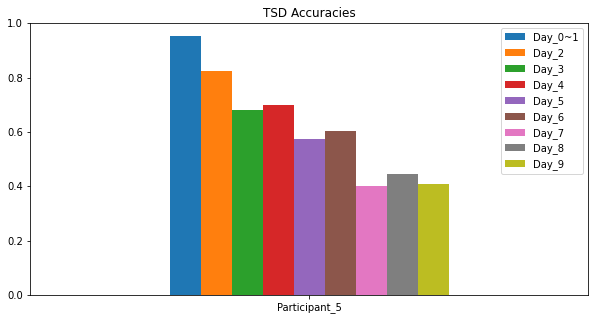

In [12]:
TSD_df.transpose().plot.bar(rot=0, figsize=(10,5))
plt.title("TSD Accuracies")
plt.show()

In [13]:
from TrainingsAndEvaluations.ForTrainingSessions.utils import get_gesture_accuracies

In [14]:
ground_truths = results[1]
predictions = results[2]
print("ground_truths  = ", np.shape(ground_truths))
print("predictions = ", np.shape(predictions))
m_name = "Loc1_Sub"
n_name = "Day0~1->"
df = get_gesture_accuracies(ground_truths, predictions, number_of_classes=number_of_classes, 
                            m_name=m_name, n_name=n_name, path=save_TSD, algo_name=algo_name,
                           index_participant_list_customized=index_participant_list,
                           lump_day_at_participant=5)
df = pd.read_csv(save_TSD+'/'+algo_name+'.csv')
df

ground_truths  =  (1, 9)
predictions =  (1, 9)
index_participant_list  ['0~1', 2, 3, 4, 5, 6, 7, 8, 9]
accuracies_gestures =  (22, 9)


,Unnamed: 0,Loc1_Sub5_Day0~1->0~1,Loc1_Sub5_Day0~1->2,Loc1_Sub5_Day0~1->3,Loc1_Sub5_Day0~1->4,Loc1_Sub5_Day0~1->5,Loc1_Sub5_Day0~1->6,Loc1_Sub5_Day0~1->7,Loc1_Sub5_Day0~1->8,Loc1_Sub5_Day0~1->9
0,M0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,M1,0.980769,1.000000,0.384615,0.769231,0.961538,0.500000,0.153846,0.269231,0.384615
2,M2,0.961538,0.576923,0.538462,0.769231,0.500000,0.461538,0.000000,0.461538,0.384615
3,M3,1.000000,0.807692,0.038462,0.423077,0.038462,0.000000,0.000000,0.000000,0.000000
4,M4,0.788462,0.846154,0.000000,0.153846,0.000000,0.000000,0.000000,0.000000,0.000000
5,M5,1.000000,0.961538,0.846154,1.000000,0.846154,0.884615,0.000000,0.653846,0.269231
6,M6,1.000000,1.000000,0.230769,1.000000,0.576923,0.384615,0.230769,0.115385,0.769231
7,M7,1.000000,0.538462,1.000000,0.961538,0.615385,1.000000,0.730769,0.653846,0.653846
8,M8,1.000000,0.769231,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
9,M9,1.000000,0.961538,0.769231,0.807692,0.692308,0.884615,0.730769,0.769231,0.576923


# 2. DANN
* `train_DANN`: train DANN model using the first set of training weights from base model
    * num_sessions-1 sets of training weights will be saved
* `test_DANN_on_training_sessions`: test DANN model

In [15]:
from TrainingsAndEvaluations.ForTrainingSessions.train_tsd_dnn_DA import train_DANN, test_DANN_on_training_sessions

In [16]:
# train_DANN(examples_datasets_train, labels_datasets_train, 
#           num_kernels=num_kernels,
#           path_weights_fine_tuning=path_TSD,
#           number_of_classes=number_of_classes,
#           number_of_cycles_total = number_of_cycles_total,
#           number_of_cycle_for_first_training = number_of_cycle_for_first_training,
#           batch_size=batch_size,
#           feature_vector_input_length=feature_vector_input_length,
#           path_weights_to_save_to=path_DANN, learning_rate=learning_rate)

GET one participant_examples  (9,)
   GET one training_index_examples  (8, 572, 252)  at  0
   GOT one group XY  (4576, 252)    (4576,)
       one group XY test  (0,)    (0,)
       one group XY train (4118, 252)    (4118,)
       one group XY valid (458, 252)    (458, 252)
   GET one training_index_examples  (4, 572, 252)  at  1
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (0,)    (0,)
       one group XY train (2059, 252)    (2059,)
       one group XY valid (229, 252)    (229, 252)
   GET one training_index_examples  (4, 572, 252)  at  2
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (0,)    (0,)
       one group XY train (2059, 252)    (2059,)
       one group XY valid (229, 252)    (229, 252)
   GET one training_index_examples  (4, 572, 252)  at  3
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (0,)    (0,)
       one group XY train (2059, 252)    (2059,)
       one group XY valid (229, 252)    (229, 252)
   GE

Accuracy source 0.931641, main loss classifier 0.163203, source classification loss 0.185883, loss domain distinction 0.185558, accuracy domain distinction 0.500000
VALIDATION Loss: 0.07425328 Acc: 0.97161572
Epoch 23 of 500 took 0.426s
Accuracy source 0.937012, main loss classifier 0.159712, source classification loss 0.178805, loss domain distinction 0.187798, accuracy domain distinction 0.500000
VALIDATION Loss: 0.10240833 Acc: 0.95851528
Epoch 24 of 500 took 0.317s
Accuracy source 0.947266, main loss classifier 0.149247, source classification loss 0.157248, loss domain distinction 0.187769, accuracy domain distinction 0.500000
VALIDATION Loss: 0.11176700 Acc: 0.95633188
Epoch 25 of 500 took 0.455s
Accuracy source 0.944824, main loss classifier 0.153602, source classification loss 0.166413, loss domain distinction 0.186134, accuracy domain distinction 0.500000
VALIDATION Loss: 0.09110668 Acc: 0.9628821
Epoch 26 of 500 took 0.348s
Accuracy source 0.944824, main loss classifier 0.1452

Accuracy source 0.944824, main loss classifier 0.150521, source classification loss 0.159346, loss domain distinction 0.188001, accuracy domain distinction 0.500000
VALIDATION Loss: 0.10088512 Acc: 0.9628821
Epoch 25 of 500 took 0.229s
Accuracy source 0.934082, main loss classifier 0.161898, source classification loss 0.183971, loss domain distinction 0.185666, accuracy domain distinction 0.500000
VALIDATION Loss: 0.09584443 Acc: 0.95414847
Epoch 26 of 500 took 0.231s
Accuracy source 0.946289, main loss classifier 0.145989, source classification loss 0.152052, loss domain distinction 0.187349, accuracy domain distinction 0.499756
VALIDATION Loss: 0.11828817 Acc: 0.95414847
Epoch 27 of 500 took 0.233s
Accuracy source 0.949707, main loss classifier 0.148390, source classification loss 0.156012, loss domain distinction 0.188078, accuracy domain distinction 0.500000
VALIDATION Loss: 0.17503989 Acc: 0.9279476
Epoch 28 of 500 took 0.229s
Accuracy source 0.938477, main loss classifier 0.15580

Accuracy source 0.930664, main loss classifier 0.162714, source classification loss 0.180803, loss domain distinction 0.190807, accuracy domain distinction 0.499756
VALIDATION Loss: 0.13641451 Acc: 0.94323144
Epoch    33: reducing learning rate of group 0 to 1.0060e-04.
New best validation loss:  0.1364145129919052
Epoch 6 of 500 took 0.238s
Accuracy source 0.935547, main loss classifier 0.163700, source classification loss 0.184633, loss domain distinction 0.192362, accuracy domain distinction 0.499756
VALIDATION Loss: 0.15995201 Acc: 0.92139738
Epoch 7 of 500 took 0.257s
Accuracy source 0.942383, main loss classifier 0.162872, source classification loss 0.182529, loss domain distinction 0.192376, accuracy domain distinction 0.499512
VALIDATION Loss: 0.16706367 Acc: 0.93449782
Epoch 8 of 500 took 0.293s
Accuracy source 0.937988, main loss classifier 0.153361, source classification loss 0.164338, loss domain distinction 0.188261, accuracy domain distinction 0.500000
VALIDATION Loss: 0.

Accuracy source 0.941895, main loss classifier 0.150453, source classification loss 0.160880, loss domain distinction 0.188627, accuracy domain distinction 0.500000
VALIDATION Loss: 0.15612380 Acc: 0.93449782
Epoch 40 of 500 took 0.234s
Accuracy source 0.945312, main loss classifier 0.149224, source classification loss 0.159992, loss domain distinction 0.184661, accuracy domain distinction 0.499756
VALIDATION Loss: 0.13948172 Acc: 0.94541485
Epoch 41 of 500 took 0.230s
Accuracy source 0.950684, main loss classifier 0.137669, source classification loss 0.137735, loss domain distinction 0.182865, accuracy domain distinction 0.500000
VALIDATION Loss: 0.14330809 Acc: 0.93886463
Epoch 42 of 500 took 0.275s
Accuracy source 0.947266, main loss classifier 0.149810, source classification loss 0.160951, loss domain distinction 0.183924, accuracy domain distinction 0.500000
VALIDATION Loss: 0.18112440 Acc: 0.9279476
Epoch 43 of 500 took 0.277s
Accuracy source 0.953613, main loss classifier 0.1366

Accuracy source 0.935547, main loss classifier 0.160022, source classification loss 0.176754, loss domain distinction 0.189082, accuracy domain distinction 0.500244
VALIDATION Loss: 0.23249531 Acc: 0.90829694
Epoch 7 of 500 took 0.231s
Accuracy source 0.936523, main loss classifier 0.165952, source classification loss 0.189991, loss domain distinction 0.190260, accuracy domain distinction 0.500732
VALIDATION Loss: 0.30136690 Acc: 0.88646288
Epoch 8 of 500 took 0.235s
Accuracy source 0.942383, main loss classifier 0.152399, source classification loss 0.163730, loss domain distinction 0.187150, accuracy domain distinction 0.500244
VALIDATION Loss: 0.32147467 Acc: 0.8930131
Epoch 9 of 500 took 0.231s
Accuracy source 0.943359, main loss classifier 0.158877, source classification loss 0.174556, loss domain distinction 0.189095, accuracy domain distinction 0.500000
VALIDATION Loss: 0.22521220 Acc: 0.90829694
Epoch 10 of 500 took 0.229s
Accuracy source 0.934570, main loss classifier 0.164116,

Accuracy source 0.938477, main loss classifier 0.158885, source classification loss 0.176298, loss domain distinction 0.185679, accuracy domain distinction 0.499756
VALIDATION Loss: 0.47445181 Acc: 0.84716157
Epoch 15 of 500 took 0.241s
Accuracy source 0.938965, main loss classifier 0.150111, source classification loss 0.160315, loss domain distinction 0.185120, accuracy domain distinction 0.500000
VALIDATION Loss: 0.44753006 Acc: 0.85371179
Epoch 16 of 500 took 0.247s
Accuracy source 0.941406, main loss classifier 0.151191, source classification loss 0.161806, loss domain distinction 0.183577, accuracy domain distinction 0.500488
VALIDATION Loss: 0.54868448 Acc: 0.82751092
Epoch 17 of 500 took 0.230s
Accuracy source 0.941895, main loss classifier 0.148965, source classification loss 0.158364, loss domain distinction 0.183981, accuracy domain distinction 0.500244
VALIDATION Loss: 0.40982744 Acc: 0.86244541
Epoch 18 of 500 took 0.231s
Accuracy source 0.940430, main loss classifier 0.159

Accuracy source 0.939453, main loss classifier 0.161349, source classification loss 0.181656, loss domain distinction 0.188835, accuracy domain distinction 0.500000
VALIDATION Loss: 0.37903324 Acc: 0.86462882
Epoch 8 of 500 took 0.229s
Accuracy source 0.938477, main loss classifier 0.157267, source classification loss 0.171928, loss domain distinction 0.191023, accuracy domain distinction 0.500244
VALIDATION Loss: 0.48165876 Acc: 0.84934498
Epoch 9 of 500 took 0.231s
Accuracy source 0.939941, main loss classifier 0.153569, source classification loss 0.164610, loss domain distinction 0.187941, accuracy domain distinction 0.500244
VALIDATION Loss: 0.33302242 Acc: 0.87336245
Epoch 10 of 500 took 0.231s
Accuracy source 0.937500, main loss classifier 0.162092, source classification loss 0.180528, loss domain distinction 0.190560, accuracy domain distinction 0.500000
VALIDATION Loss: 0.39619333 Acc: 0.8580786
Epoch 11 of 500 took 0.229s
Accuracy source 0.939453, main loss classifier 0.157844

In [17]:
algo_name = "DANN"
test_DANN_on_training_sessions(examples_datasets_train, labels_datasets_train,
                              feature_vector_input_length=feature_vector_input_length,
                              num_neurons=num_kernels, path_weights_DA=path_DANN,
                              algo_name=algo_name, save_path = save_DANN, 
                              number_of_cycles_total=number_of_cycles_total,
                              number_of_cycle_for_first_training = number_of_cycle_for_first_training,
                              path_weights_normal=path_TSD, number_of_classes=number_of_classes,
                              cycle_for_test=3)

GET one participant_examples  (9,)
   GET one training_index_examples  (8, 572, 252)  at  0
   GOT one group XY  (4576, 252)    (4576,)
       one group XY test  (1144, 252)    (1144, 252)
       one group XY train (4118, 252)    (4118,)
       one group XY valid (458, 252)    (458, 252)
   GET one training_index_examples  (4, 572, 252)  at  1
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (572, 252)    (572, 252)
       one group XY train (2059, 252)    (2059,)
       one group XY valid (229, 252)    (229, 252)
   GET one training_index_examples  (4, 572, 252)  at  2
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (572, 252)    (572, 252)
       one group XY train (2059, 252)    (2059,)
       one group XY valid (229, 252)    (229, 252)
   GET one training_index_examples  (4, 572, 252)  at  3
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (572, 252)    (572, 252)
       one group XY train (2059, 252)    (2059,)
      

In [18]:
results_filename = save_DANN + '/predictions_' + algo_name + ".npy"
results = np.load(results_filename, allow_pickle=True)
DANN_acc = results[0]
DANN_acc_overall = np.mean(DANN_acc)
DANN_df = pd.DataFrame(DANN_acc.transpose(), 
                       index = [f'Day_{i}' for i in index_participant_list],
                        columns = ['Participant_5'])
DANN_df

,Participant_5
Day_0~1,0.952797
Day_2,0.826923
Day_3,0.72028
Day_4,0.755245
Day_5,0.627622
Day_6,0.692308
Day_7,0.45979
Day_8,0.491259
Day_9,0.433566


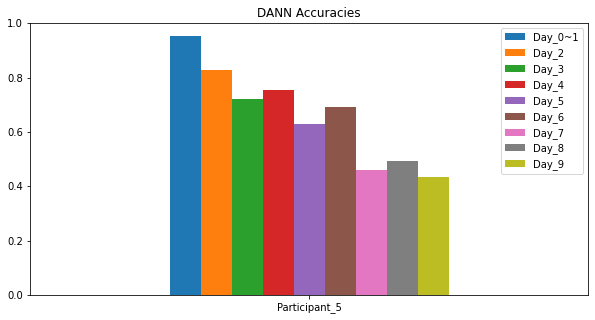

In [19]:
DANN_df.transpose().plot.bar(rot=0, figsize=(10,5))
plt.title("DANN Accuracies")
plt.show()

In [20]:
ground_truths = results[1]
predictions = results[2]
print("ground_truths  = ", np.shape(ground_truths))
print("predictions = ", np.shape(predictions))
df = get_gesture_accuracies(ground_truths, predictions, number_of_classes=number_of_classes, 
                            m_name=m_name, n_name=n_name, path=save_TSD, algo_name=algo_name,
                           index_participant_list_customized=index_participant_list,
                           lump_day_at_participant=5)
df = pd.read_csv(save_DANN+'/'+algo_name+'.csv')
df

ground_truths  =  (1, 9)
predictions =  (1, 9)
index_participant_list  ['0~1', 2, 3, 4, 5, 6, 7, 8, 9]
accuracies_gestures =  (22, 9)


,Unnamed: 0,Loc1_Sub5_Day0~1->0~1,Loc1_Sub5_Day0~1->2,Loc1_Sub5_Day0~1->3,Loc1_Sub5_Day0~1->4,Loc1_Sub5_Day0~1->5,Loc1_Sub5_Day0~1->6,Loc1_Sub5_Day0~1->7,Loc1_Sub5_Day0~1->8,Loc1_Sub5_Day0~1->9
0,M0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.846154,1.000000
1,M1,0.980769,1.000000,0.615385,0.807692,1.000000,0.769231,0.615385,0.653846,0.653846
2,M2,0.961538,0.769231,0.576923,0.846154,0.538462,0.653846,0.230769,0.576923,0.730769
3,M3,1.000000,0.769231,0.038462,0.653846,0.423077,0.192308,0.000000,0.000000,0.000000
4,M4,0.788462,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,M5,1.000000,0.961538,1.000000,0.807692,0.807692,0.961538,0.038462,0.576923,0.269231
6,M6,1.000000,1.000000,0.384615,1.000000,0.653846,0.384615,0.192308,0.384615,1.000000
7,M7,1.000000,0.307692,0.961538,0.807692,0.461538,1.000000,0.576923,0.653846,0.692308
8,M8,1.000000,0.653846,1.000000,1.000000,1.000000,0.923077,0.923077,0.615385,0.423077
9,M9,1.000000,1.000000,0.730769,0.615385,0.576923,0.769231,0.230769,0.692308,0.307692


# 3. SCADANN

* `run_SCADANN_training_sessions`: train SCADANN model. The first session uses TSD model_0 wegits; others use DANN weights
    * specify `percentage_same_gesture_stable` based on the performance of most pseudo labels: 
        * print accuracies out and check what percentage will optimize `ACCURACY MODEL` and `ACCURACY PSEUDO` without cutting out too much data 
    * num_sessions-1 sets of training weights will be saved


In [21]:
from TrainingsAndEvaluations.ForTrainingSessions.train_tsd_dnn_SCADANN import \
    run_SCADANN_training_sessions, test_network_SCADANN

In [22]:
# percentage_same_gesture_stable = 0.75 
# run_SCADANN_training_sessions(examples_datasets=examples_datasets_train, labels_datasets=labels_datasets_train,
#                               num_kernels=num_kernels, feature_vector_input_length=feature_vector_input_length,
#                               path_weights_to_save_to=path_SCADANN,
#                               path_weights_Adversarial_training=path_DANN,
#                               path_weights_Normal_training=path_TSD,
#                               number_of_cycles_total = number_of_cycles_total, 
#                               number_of_cycle_for_first_training = number_of_cycle_for_first_training,
#                               number_of_classes=number_of_classes,
#                               learning_rate=learning_rate)

GET one participant_examples  (9,)
   GET one training_index_examples  (8, 572, 252)  at  0
   GOT one group XY  (4576, 252)    (4576,)
       one group XY test  (0,)    (0,)
       one group XY train (4576, 252)    (4576,)
   GET one training_index_examples  (4, 572, 252)  at  1
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (0,)    (0,)
       one group XY train (2288, 252)    (2288,)
   GET one training_index_examples  (4, 572, 252)  at  2
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (0,)    (0,)
       one group XY train (2288, 252)    (2288,)
   GET one training_index_examples  (4, 572, 252)  at  3
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (0,)    (0,)
       one group XY train (2288, 252)    (2288,)
   GET one training_index_examples  (4, 572, 252)  at  4
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (0,)    (0,)
       one group XY train (2288, 252)    (2288,)
   GET one training_

/home/laiy/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/laiy/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Accuracy total 0.892428, main loss classifier 0.438295, source accuracy 0.932091 source classification loss 0.175593, target accuracy 0.852764 target loss 0.462704 accuracy domain distinction 0.500901 loss domain distinction 1.191465,
VALIDATION Loss: 0.35993299 Acc: 0.89386792
New best validation loss:  0.3599329888820648
Epoch 2 of 500 took 0.354s
Accuracy total 0.895132, main loss classifier 0.408784, source accuracy 0.930889 source classification loss 0.186189, target accuracy 0.859375 target loss 0.409969 accuracy domain distinction 0.500300 loss domain distinction 1.107047,
VALIDATION Loss: 0.33608604 Acc: 0.90330189
New best validation loss:  0.3360860390322549
Epoch 3 of 500 took 0.340s
Accuracy total 0.897837, main loss classifier 0.421586, source accuracy 0.927885 source classification loss 0.204240, target accuracy 0.867788 target loss 0.419629 accuracy domain distinction 0.500601 loss domain distinction 1.096520,
VALIDATION Loss: 0.31078851 Acc: 0.91037736
New best validati

Accuracy total 0.919772, main loss classifier 0.338995, source accuracy 0.943510 source classification loss 0.167355, target accuracy 0.896034 target loss 0.299098 accuracy domain distinction 0.500000 loss domain distinction 1.057680,
VALIDATION Loss: 0.26561458 Acc: 0.90566038
Epoch 28 of 500 took 0.345s
Accuracy total 0.913462, main loss classifier 0.361487, source accuracy 0.924880 source classification loss 0.212206, target accuracy 0.902043 target loss 0.300391 accuracy domain distinction 0.500000 loss domain distinction 1.051886,
VALIDATION Loss: 0.24413155 Acc: 0.91745283
Epoch 29 of 500 took 0.341s
Accuracy total 0.925180, main loss classifier 0.330619, source accuracy 0.942909 source classification loss 0.174332, target accuracy 0.907452 target loss 0.276817 accuracy domain distinction 0.500000 loss domain distinction 1.050448,
VALIDATION Loss: 0.20454640 Acc: 0.92924528
Epoch 30 of 500 took 0.340s
Accuracy total 0.925180, main loss classifier 0.336110, source accuracy 0.93990

Finish segment dataset
Finish pseudo_labels
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5   AFTER:  0.0  len before:  26   len after:  7
BEFORE:  0.7692307692307693   AFTER:  0.7692307692307693  len before:  26   len after:  26
BEFORE:  0.34615384615384615   AFTER:  0.0  len before:  26   len after:  5
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6538461538461539   AFTER:  0.5  len before:  26   len after:  4
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6538461538461539   AFTER:  0.7692307692307693  len before:  26   len after:  26
BEFORE:  0.4230769230769231   AFTER:  0.4230769230769231  len before:  26   len after:  26
BEFORE:  0.7307692307692307   AFTER:  1.0  len before:  26   len after:  18
BEFORE:  0.7692307692307693   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   

Accuracy total 0.874687, main loss classifier 0.484760, source accuracy 0.910625 source classification loss 0.255283, target accuracy 0.838750 target loss 0.498833 accuracy domain distinction 0.500625 loss domain distinction 1.077017,
VALIDATION Loss: 0.31126656 Acc: 0.90074442
New best validation loss:  0.3112665648971285
Epoch 7 of 500 took 0.367s
Accuracy total 0.870000, main loss classifier 0.512876, source accuracy 0.901250 source classification loss 0.296733, target accuracy 0.838750 target loss 0.516347 accuracy domain distinction 0.498750 loss domain distinction 1.063358,
VALIDATION Loss: 0.30268978 Acc: 0.88833747
New best validation loss:  0.30268978221075876
Epoch 8 of 500 took 0.331s
Accuracy total 0.873125, main loss classifier 0.467586, source accuracy 0.898750 source classification loss 0.274009, target accuracy 0.847500 target loss 0.447301 accuracy domain distinction 0.498750 loss domain distinction 1.069305,
VALIDATION Loss: 0.36622598 Acc: 0.86848635
Epoch 9 of 500 t

Accuracy total 0.891250, main loss classifier 0.440251, source accuracy 0.913750 source classification loss 0.263144, target accuracy 0.868750 target loss 0.406724 accuracy domain distinction 0.500625 loss domain distinction 1.053172,
VALIDATION Loss: 0.36157773 Acc: 0.86848635
Epoch    32: reducing learning rate of group 0 to 8.0480e-07.
Epoch 33 of 500 took 0.329s
Accuracy total 0.879375, main loss classifier 0.458410, source accuracy 0.906250 source classification loss 0.265168, target accuracy 0.852500 target loss 0.441971 accuracy domain distinction 0.499688 loss domain distinction 1.048408,
VALIDATION Loss: 0.30815374 Acc: 0.88585608
Epoch 34 of 500 took 0.329s
Accuracy total 0.879062, main loss classifier 0.452407, source accuracy 0.910000 source classification loss 0.243372, target accuracy 0.848125 target loss 0.449043 accuracy domain distinction 0.499688 loss domain distinction 1.061995,
VALIDATION Loss: 0.32991060 Acc: 0.88585608
Epoch 35 of 500 took 0.332s
Accuracy total 0.

Finish segment dataset
Finish pseudo_labels
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5   AFTER:  0.0  len before:  26   len after:  7
BEFORE:  0.7692307692307693   AFTER:  0.7692307692307693  len before:  26   len after:  26
BEFORE:  0.34615384615384615   AFTER:  0.0  len before:  26   len after:  5
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6538461538461539   AFTER:  0.5  len before:  26   len after:  4
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6538461538461539   AFTER:  0.7692307692307693  len before:  26   len after:  26
BEFORE:  0.4230769230769231   AFTER:  0.4230769230769231  len before:  26   len after:  26
BEFORE:  0.7307692307692307   AFTER:  1.0  len before:  26   len after:  18
BEFORE:  0.7692307692307693   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   

STARTING TRAINING
Accuracy total 0.851562, main loss classifier 0.599789, source accuracy 0.877604 source classification loss 0.382038, target accuracy 0.825521 target loss 0.587757 accuracy domain distinction 0.500326 loss domain distinction 1.148917,
VALIDATION Loss: 0.30954473 Acc: 0.9025641
New best validation loss:  0.3095447282705988
Epoch 2 of 500 took 0.319s
Accuracy total 0.866211, main loss classifier 0.497558, source accuracy 0.864583 source classification loss 0.363289, target accuracy 0.867839 target loss 0.411820 accuracy domain distinction 0.500651 loss domain distinction 1.100036,
VALIDATION Loss: 0.23463452 Acc: 0.91794872
New best validation loss:  0.2346345212842737
Epoch 3 of 500 took 0.317s
Accuracy total 0.873372, main loss classifier 0.497466, source accuracy 0.876953 source classification loss 0.376568, target accuracy 0.869792 target loss 0.400779 accuracy domain distinction 0.498047 loss domain distinction 1.087925,
VALIDATION Loss: 0.27597829 Acc: 0.91282051


Accuracy total 0.913086, main loss classifier 0.360575, source accuracy 0.901042 source classification loss 0.290754, target accuracy 0.925130 target loss 0.222757 accuracy domain distinction 0.500000 loss domain distinction 1.038191,
VALIDATION Loss: 0.15717596 Acc: 0.94615385
Epoch 28 of 500 took 0.321s
Accuracy total 0.914062, main loss classifier 0.358383, source accuracy 0.899740 source classification loss 0.292560, target accuracy 0.928385 target loss 0.217486 accuracy domain distinction 0.500000 loss domain distinction 1.033608,
VALIDATION Loss: 0.14584059 Acc: 0.94871795
New best validation loss:  0.14584059161799295
Epoch 29 of 500 took 0.327s
Accuracy total 0.909831, main loss classifier 0.361788, source accuracy 0.890625 source classification loss 0.292880, target accuracy 0.929036 target loss 0.223587 accuracy domain distinction 0.500000 loss domain distinction 1.035549,
VALIDATION Loss: 0.19729066 Acc: 0.93589744
Epoch 30 of 500 took 0.368s
Accuracy total 0.912760, main lo

Finish segment dataset
Finish pseudo_labels
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5   AFTER:  0.0  len before:  26   len after:  7
BEFORE:  0.7692307692307693   AFTER:  0.7692307692307693  len before:  26   len after:  26
BEFORE:  0.34615384615384615   AFTER:  0.0  len before:  26   len after:  5
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6538461538461539   AFTER:  0.5  len before:  26   len after:  4
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6538461538461539   AFTER:  0.7692307692307693  len before:  26   len after:  26
BEFORE:  0.4230769230769231   AFTER:  0.4230769230769231  len before:  26   len after:  26
BEFORE:  0.7307692307692307   AFTER:  1.0  len before:  26   len after:  18
BEFORE:  0.7692307692307693   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   

Finish segment dataset
Finish pseudo_labels
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  9
BEFORE:  0.38461538461538464   AFTER:  0.5  len before:  26   len after:  26
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6153846153846154   AFTER:  1.0  len before:  26   len after:  18
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.7692307692307693   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5769230769230769   AFTER:  0.7692307692307693  len before:  26   len after:  26
BEFORE:  0.11538461538461539   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.6538461538461539   AFTER:  1.0  len before:  26

Accuracy total 0.841471, main loss classifier 0.581097, source accuracy 0.867188 source classification loss 0.406410, target accuracy 0.815755 target loss 0.545656 accuracy domain distinction 0.500000 loss domain distinction 1.050640,
VALIDATION Loss: 0.60748805 Acc: 0.90956072
Epoch 7 of 500 took 0.316s
Accuracy total 0.855143, main loss classifier 0.570014, source accuracy 0.877604 source classification loss 0.397761, target accuracy 0.832682 target loss 0.535061 accuracy domain distinction 0.500000 loss domain distinction 1.036034,
VALIDATION Loss: 0.37397589 Acc: 0.85271318
Epoch 8 of 500 took 0.329s
Accuracy total 0.860677, main loss classifier 0.542526, source accuracy 0.880859 source classification loss 0.359616, target accuracy 0.840495 target loss 0.516211 accuracy domain distinction 0.500000 loss domain distinction 1.046128,
VALIDATION Loss: 0.56489828 Acc: 0.89922481
Epoch 9 of 500 took 0.343s
Accuracy total 0.857422, main loss classifier 0.546068, source accuracy 0.873698 s

Finish segment dataset
Finish pseudo_labels
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5   AFTER:  0.0  len before:  26   len after:  7
BEFORE:  0.7692307692307693   AFTER:  0.7692307692307693  len before:  26   len after:  26
BEFORE:  0.34615384615384615   AFTER:  0.0  len before:  26   len after:  5
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6538461538461539   AFTER:  0.5  len before:  26   len after:  4
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6538461538461539   AFTER:  0.7692307692307693  len before:  26   len after:  26
BEFORE:  0.4230769230769231   AFTER:  0.4230769230769231  len before:  26   len after:  26
BEFORE:  0.7307692307692307   AFTER:  1.0  len before:  26   len after:  18
BEFORE:  0.7692307692307693   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   

BEFORE:  0.38461538461538464   AFTER:  1.0  len before:  26   len after:  7
BEFORE:  0.11538461538461539   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.7692307692307693   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.038461538461538464   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.23076923076923078   AFTER:  0.0  len before:  26   len after:  8
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.7307692307692307   AFTER:  1.0  len before:  26   len after:  26
ACCURACY MODEL:  0.7473776223776224   Accuracy pseudo: 0.8564102564102564  len pseudo:  1950    len predictions 2288
HANDLING NEW 

BEFORE:  0.7692307692307693   AFTER:  0.7692307692307693  len before:  26   len after:  26
BEFORE:  0.07692307692307693   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.23076923076923078   AFTER:  1.0  len before:  26   len after:  1
BEFORE:  0.6538461538461539   AFTER:  1.0  len before:  26   len after:  17
BEFORE:  0.19230769230769232   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.07692307692307693   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.7692307692307693   AFTER:  0.7692307692307693  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  

Accuracy total 0.847656, main loss classifier 0.587259, source accuracy 0.855469 source classification loss 0.443180, target accuracy 0.839844 target loss 0.519493 accuracy domain distinction 0.501302 loss domain distinction 1.059232,
VALIDATION Loss: 0.42041165 Acc: 0.90428212
Epoch 9 of 500 took 0.316s
Accuracy total 0.860352, main loss classifier 0.565402, source accuracy 0.868490 source classification loss 0.432227, target accuracy 0.852214 target loss 0.485932 accuracy domain distinction 0.500651 loss domain distinction 1.063232,
VALIDATION Loss: 0.34408830 Acc: 0.90176322
New best validation loss:  0.3440883031913212
Epoch 10 of 500 took 0.328s
Accuracy total 0.849284, main loss classifier 0.569778, source accuracy 0.859375 source classification loss 0.427876, target accuracy 0.839193 target loss 0.496215 accuracy domain distinction 0.499674 loss domain distinction 1.077317,
VALIDATION Loss: 0.36953402 Acc: 0.88916877
Epoch 11 of 500 took 0.319s
Accuracy total 0.847005, main loss

Accuracy total 0.874023, main loss classifier 0.495959, source accuracy 0.885417 source classification loss 0.372512, target accuracy 0.862630 target loss 0.409302 accuracy domain distinction 0.500000 loss domain distinction 1.050525,
VALIDATION Loss: 0.31944813 Acc: 0.90176322
Epoch 35 of 500 took 0.315s
Accuracy total 0.868490, main loss classifier 0.504084, source accuracy 0.869792 source classification loss 0.375833, target accuracy 0.867188 target loss 0.421702 accuracy domain distinction 0.500000 loss domain distinction 1.053167,
VALIDATION Loss: 0.34277771 Acc: 0.89420655
Epoch    35: reducing learning rate of group 0 to 4.0240e-06.
Epoch 36 of 500 took 0.320s
Accuracy total 0.872070, main loss classifier 0.496444, source accuracy 0.874349 source classification loss 0.387412, target accuracy 0.869792 target loss 0.396927 accuracy domain distinction 0.500977 loss domain distinction 1.042748,
VALIDATION Loss: 0.39192492 Acc: 0.90428212
Epoch 37 of 500 took 0.316s
Accuracy total 0.

Finish segment dataset
Finish pseudo_labels
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5   AFTER:  0.0  len before:  26   len after:  7
BEFORE:  0.7692307692307693   AFTER:  0.7692307692307693  len before:  26   len after:  26
BEFORE:  0.34615384615384615   AFTER:  0.0  len before:  26   len after:  5
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6538461538461539   AFTER:  0.5  len before:  26   len after:  4
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6538461538461539   AFTER:  0.7692307692307693  len before:  26   len after:  26
BEFORE:  0.4230769230769231   AFTER:  0.4230769230769231  len before:  26   len after:  26
BEFORE:  0.7307692307692307   AFTER:  1.0  len before:  26   len after:  18
BEFORE:  0.7692307692307693   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   

BEFORE:  0.038461538461538464   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.23076923076923078   AFTER:  0.0  len before:  26   len after:  8
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.7307692307692307   AFTER:  1.0  len before:  26   len after:  26
ACCURACY MODEL:  0.7473776223776224   Accuracy pseudo: 0.8564102564102564  len pseudo:  1950    len predictions 2288
HANDLING NEW SESSION  4
Finish segment dataset
Finish pseudo_labels
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  9
BEFORE:  0.38461538461538464   AFTER:  0.5  len before:  26   len after:  26
BEFORE:  0.84615384615

BEFORE:  0.7692307692307693   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5384615384615384   AFTER:  0.6470588235294118  len before:  26   len after:  17
BEFORE:  0.19230769230769232   AFTER:  0.38461538461538464  len before:  26   len after:  26
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6923076923076923   AFTER:  1.0  len before:  26   len after:  26
ACCURACY MODEL:  0.48732517482517484   Accuracy pseudo: 0.5804123711340207  len pseudo:  1940    len predictions 2288
STARTING TRAINING
Accuracy total 0.772786, main loss classifier 0.992845, source accuracy 0.836589 source classification loss 0.562818, target accuracy 0.708984 target loss 1.187133 accuracy domain distinction 0

Finish segment dataset
Finish pseudo_labels
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5   AFTER:  0.0  len before:  26   len after:  7
BEFORE:  0.7692307692307693   AFTER:  0.7692307692307693  len before:  26   len after:  26
BEFORE:  0.34615384615384615   AFTER:  0.0  len before:  26   len after:  5
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6538461538461539   AFTER:  0.5  len before:  26   len after:  4
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6538461538461539   AFTER:  0.7692307692307693  len before:  26   len after:  26
BEFORE:  0.4230769230769231   AFTER:  0.4230769230769231  len before:  26   len after:  26
BEFORE:  0.7307692307692307   AFTER:  1.0  len before:  26   len after:  18
BEFORE:  0.7692307692307693   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   

Finish segment dataset
Finish pseudo_labels
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  9
BEFORE:  0.38461538461538464   AFTER:  0.5  len before:  26   len after:  26
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6153846153846154   AFTER:  1.0  len before:  26   len after:  18
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.7692307692307693   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5769230769230769   AFTER:  0.7692307692307693  len before:  26   len after:  26
BEFORE:  0.11538461538461539   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.6538461538461539   AFTER:  1.0  len before:  26

Finish segment dataset
Finish pseudo_labels
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6538461538461539   AFTER:  0.6538461538461539  len before:  26   len after:  26
BEFORE:  0.5   AFTER:  0.5  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  7
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  17
BEFORE:  0.23076923076923078   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.38461538461538464   AFTER:  0.0  len before:  26   len after:  12
BEFORE:  0.6153846153846154   AFTER:  1.0  len before:  26   len after:  17
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.2692307692307692   AFTER:  0.0  len before:  26   len after:  6
BEFORE:  0.11538461538461539   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.34615384615384615   AFTER:  1.0  len before:  26   len after:  7
BEFORE:  0.5   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6538461538461539

STARTING TRAINING
Accuracy total 0.755774, main loss classifier 0.990880, source accuracy 0.805027 source classification loss 0.721460, target accuracy 0.706522 target loss 1.015545 accuracy domain distinction 0.500000 loss domain distinction 1.223772,
VALIDATION Loss: 0.63465704 Acc: 0.79356568
New best validation loss:  0.6346570352713267
Epoch 2 of 500 took 0.317s
Accuracy total 0.802989, main loss classifier 0.782933, source accuracy 0.836957 source classification loss 0.567181, target accuracy 0.769022 target loss 0.770470 accuracy domain distinction 0.498981 loss domain distinction 1.141076,
VALIDATION Loss: 0.50144913 Acc: 0.84718499
New best validation loss:  0.5014491329590479
Epoch 3 of 500 took 0.306s
Accuracy total 0.800611, main loss classifier 0.792154, source accuracy 0.824728 source classification loss 0.598312, target accuracy 0.776495 target loss 0.763488 accuracy domain distinction 0.497962 loss domain distinction 1.112539,
VALIDATION Loss: 0.49209863 Acc: 0.86327078

Accuracy total 0.837636, main loss classifier 0.622620, source accuracy 0.843750 source classification loss 0.494122, target accuracy 0.831522 target loss 0.541121 accuracy domain distinction 0.500000 loss domain distinction 1.049984,
VALIDATION Loss: 0.42906646 Acc: 0.8766756
Epoch 28 of 500 took 0.303s
Accuracy total 0.844769, main loss classifier 0.588414, source accuracy 0.852582 source classification loss 0.471083, target accuracy 0.836957 target loss 0.495021 accuracy domain distinction 0.500340 loss domain distinction 1.053617,
VALIDATION Loss: 0.38936758 Acc: 0.8766756
Epoch 29 of 500 took 0.304s
Accuracy total 0.834579, main loss classifier 0.608822, source accuracy 0.843071 source classification loss 0.486518, target accuracy 0.826087 target loss 0.519650 accuracy domain distinction 0.499660 loss domain distinction 1.057376,
VALIDATION Loss: 0.40007681 Acc: 0.87131367
Epoch    29: reducing learning rate of group 0 to 2.0120e-05.
Epoch 30 of 500 took 0.310s
Accuracy total 0.83

Finish segment dataset
Finish pseudo_labels
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5   AFTER:  0.0  len before:  26   len after:  7
BEFORE:  0.7692307692307693   AFTER:  0.7692307692307693  len before:  26   len after:  26
BEFORE:  0.34615384615384615   AFTER:  0.0  len before:  26   len after:  5
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6538461538461539   AFTER:  0.5  len before:  26   len after:  4
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6538461538461539   AFTER:  0.7692307692307693  len before:  26   len after:  26
BEFORE:  0.4230769230769231   AFTER:  0.4230769230769231  len before:  26   len after:  26
BEFORE:  0.7307692307692307   AFTER:  1.0  len before:  26   len after:  18
BEFORE:  0.7692307692307693   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   

Finish segment dataset
Finish pseudo_labels
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  9
BEFORE:  0.38461538461538464   AFTER:  0.5  len before:  26   len after:  26
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6153846153846154   AFTER:  1.0  len before:  26   len after:  18
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.7692307692307693   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5769230769230769   AFTER:  0.7692307692307693  len before:  26   len after:  26
BEFORE:  0.11538461538461539   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.6538461538461539   AFTER:  1.0  len before:  26

Finish segment dataset
Finish pseudo_labels
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6538461538461539   AFTER:  0.6538461538461539  len before:  26   len after:  26
BEFORE:  0.5   AFTER:  0.5  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  7
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  17
BEFORE:  0.23076923076923078   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.38461538461538464   AFTER:  0.0  len before:  26   len after:  12
BEFORE:  0.6153846153846154   AFTER:  1.0  len before:  26   len after:  17
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.2692307692307692   AFTER:  0.0  len before:  26   len after:  6
BEFORE:  0.11538461538461539   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.34615384615384615   AFTER:  1.0  len before:  26   len after:  7
BEFORE:  0.5   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6538461538461539

STARTING TRAINING
Accuracy total 0.782670, main loss classifier 0.917865, source accuracy 0.814631 source classification loss 0.671021, target accuracy 0.750710 target loss 0.930196 accuracy domain distinction 0.502486 loss domain distinction 1.172565,
VALIDATION Loss: 0.41643783 Acc: 0.86760563
New best validation loss:  0.4164378270506859
Epoch 2 of 500 took 0.295s
Accuracy total 0.784446, main loss classifier 0.822135, source accuracy 0.807528 source classification loss 0.644675, target accuracy 0.761364 target loss 0.779738 accuracy domain distinction 0.497159 loss domain distinction 1.099284,
VALIDATION Loss: 0.44169663 Acc: 0.83380282
Epoch 3 of 500 took 0.297s
Accuracy total 0.799716, main loss classifier 0.770111, source accuracy 0.808239 source classification loss 0.612325, target accuracy 0.791193 target loss 0.708614 accuracy domain distinction 0.499290 loss domain distinction 1.096417,
VALIDATION Loss: 0.46639840 Acc: 0.85633803
Epoch 4 of 500 took 0.302s
Accuracy total 0.8

In [23]:
algo_name = "SCADANN"
test_network_SCADANN(examples_datasets_train=examples_datasets_train, labels_datasets_train=labels_datasets_train,
                     num_neurons=num_kernels, feature_vector_input_length=feature_vector_input_length,
                     path_weights_SCADANN =path_SCADANN, path_weights_normal=path_TSD,
                     algo_name=algo_name, cycle_test=3, number_of_cycles_total=number_of_cycles_total,
                     number_of_cycle_for_first_training = number_of_cycle_for_first_training,
                     number_of_classes=number_of_classes, save_path = save_SCADANN)

GET one participant_examples  (9,)
   GET one training_index_examples  (8, 572, 252)  at  0
   GOT one group XY  (4576, 252)    (4576,)
       one group XY test  (1144, 252)    (1144, 252)
       one group XY train (4118, 252)    (4118,)
       one group XY valid (458, 252)    (458, 252)
   GET one training_index_examples  (4, 572, 252)  at  1
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (572, 252)    (572, 252)
       one group XY train (2059, 252)    (2059,)
       one group XY valid (229, 252)    (229, 252)
   GET one training_index_examples  (4, 572, 252)  at  2
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (572, 252)    (572, 252)
       one group XY train (2059, 252)    (2059,)
       one group XY valid (229, 252)    (229, 252)
   GET one training_index_examples  (4, 572, 252)  at  3
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (572, 252)    (572, 252)
       one group XY train (2059, 252)    (2059,)
      

In [24]:
results_filename = save_SCADANN + '/predictions_' + algo_name + ".npy"
results = np.load(results_filename, allow_pickle=True)
SCADANN_acc = results[0]
SCADANN_acc_overall = np.mean(SCADANN_acc)
SCADANN_df = pd.DataFrame(SCADANN_acc.transpose(), 
                       index = [f'Day_{i}' for i in index_participant_list],
                        columns = ['Participant_5'])
SCADANN_df

,Participant_5
Day_0~1,0.952797
Day_2,0.881119
Day_3,0.736014
Day_4,0.807692
Day_5,0.687063
Day_6,0.722028
Day_7,0.552448
Day_8,0.548951
Day_9,0.506993


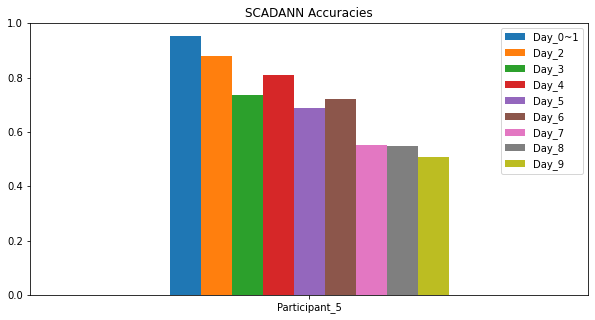

In [25]:
SCADANN_df.transpose().plot.bar(rot=0, figsize=(10,5))
plt.title("SCADANN Accuracies")
plt.show()

In [26]:
ground_truths = results[1]
predictions = results[2]
print("ground_truths  = ", np.shape(ground_truths))
print("predictions = ", np.shape(predictions))
df = get_gesture_accuracies(ground_truths, predictions, number_of_classes=number_of_classes, 
                            m_name=m_name, n_name=n_name, path=save_TSD, algo_name=algo_name,
                           index_participant_list_customized=index_participant_list,
                           lump_day_at_participant=5)
df = pd.read_csv(save_SCADANN+'/'+algo_name+'.csv')
df

ground_truths  =  (1, 9)
predictions =  (1, 9)
index_participant_list  ['0~1', 2, 3, 4, 5, 6, 7, 8, 9]
accuracies_gestures =  (22, 9)


,Unnamed: 0,Loc1_Sub5_Day0~1->0~1,Loc1_Sub5_Day0~1->2,Loc1_Sub5_Day0~1->3,Loc1_Sub5_Day0~1->4,Loc1_Sub5_Day0~1->5,Loc1_Sub5_Day0~1->6,Loc1_Sub5_Day0~1->7,Loc1_Sub5_Day0~1->8,Loc1_Sub5_Day0~1->9
0,M0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,M1,0.980769,1.000000,0.692308,0.884615,1.000000,0.846154,0.653846,0.576923,0.807692
2,M2,0.961538,0.807692,0.500000,0.961538,0.500000,0.692308,0.269231,0.461538,0.961538
3,M3,1.000000,0.846154,0.000000,0.769231,0.692308,0.115385,0.000000,0.000000,0.000000
4,M4,0.788462,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,M5,1.000000,1.000000,1.000000,1.000000,0.961538,1.000000,0.076923,0.692308,0.076923
6,M6,1.000000,1.000000,0.346154,1.000000,1.000000,0.615385,0.576923,0.538462,1.000000
7,M7,1.000000,0.538462,1.000000,0.884615,0.884615,1.000000,0.884615,1.000000,0.692308
8,M8,1.000000,0.769231,1.000000,1.000000,1.000000,0.923077,1.000000,1.000000,1.000000
9,M9,1.000000,1.000000,0.692308,0.730769,0.692308,0.884615,0.153846,0.769231,0.500000


# Conclusion
Suppose there is a ndarray of NxM dataloaders, then N group of models will be trained, and each group will have M model. Each group is independent of the other, and each model within a group is dependent on its previous training weights.

In general, overall accuracies of SCADANN are better than DANN, and DANN is better than TSD.
Occasionally accuracies of SCADANN end up a little smaller than DANN, reasons may be lack of datasets put into training model (fixed) and non-optimal percentage_same_gesture_sable (fixed). Code should be reproducible if processed dataset sticks to the shape defined above.  

The amount of increase in accuracies from DANN to SCADANN looks random. But if the base model is better at classifying one session, then its corresponding SCADANN is also better at classifying the same session. Given such result, to obtain the best performance from SCADANN, a good model trained with good data should be the starting point.

* What to check if sth goes wrong:
    * percentage_same_gesture_sable
    * number of cycles or sessions
    * shape of dataloaders (combination of train, test, valid should include all dataset)
    * shape of procssed datasets
    * directory paths of weights and results
    * if weights are stored or loaded correcltyTSD_acc_overall_one = np.mean(TSD_acc, axis=0)

In [27]:
print("TSD")
display(TSD_df)
print("DANN")
display(DANN_df)
print("SCADANN")
display(SCADANN_df)

TSD


,Participant_5
Day_0~1,0.952797
Day_2,0.825175
Day_3,0.68007
Day_4,0.699301
Day_5,0.573427
Day_6,0.604895
Day_7,0.40035
Day_8,0.445804
Day_9,0.407343


DANN


,Participant_5
Day_0~1,0.952797
Day_2,0.826923
Day_3,0.72028
Day_4,0.755245
Day_5,0.627622
Day_6,0.692308
Day_7,0.45979
Day_8,0.491259
Day_9,0.433566


SCADANN


,Participant_5
Day_0~1,0.952797
Day_2,0.881119
Day_3,0.736014
Day_4,0.807692
Day_5,0.687063
Day_6,0.722028
Day_7,0.552448
Day_8,0.548951
Day_9,0.506993


In [28]:
diff_df = SCADANN_df-TSD_df
diff_df = diff_df.drop('Day_'+index_participant_list[0])
display(diff_df)
diff_df.to_csv(save_TSD+'/diff_results/across_day_loc1_lump2_diff.csv')

,Participant_5
Day_2,0.055944
Day_3,0.055944
Day_4,0.108392
Day_5,0.113636
Day_6,0.117133
Day_7,0.152098
Day_8,0.103147
Day_9,0.09965


In [29]:
overall_acc_df = pd.DataFrame([TSD_acc_overall, DANN_acc_overall, SCADANN_acc_overall],
                             index = ["TSD", "DANN", "SCADANN"],
                             columns = ["Overall_Acc"])
overall_acc_df

,Overall_Acc
TSD,0.621018
DANN,0.662199
SCADANN,0.710567


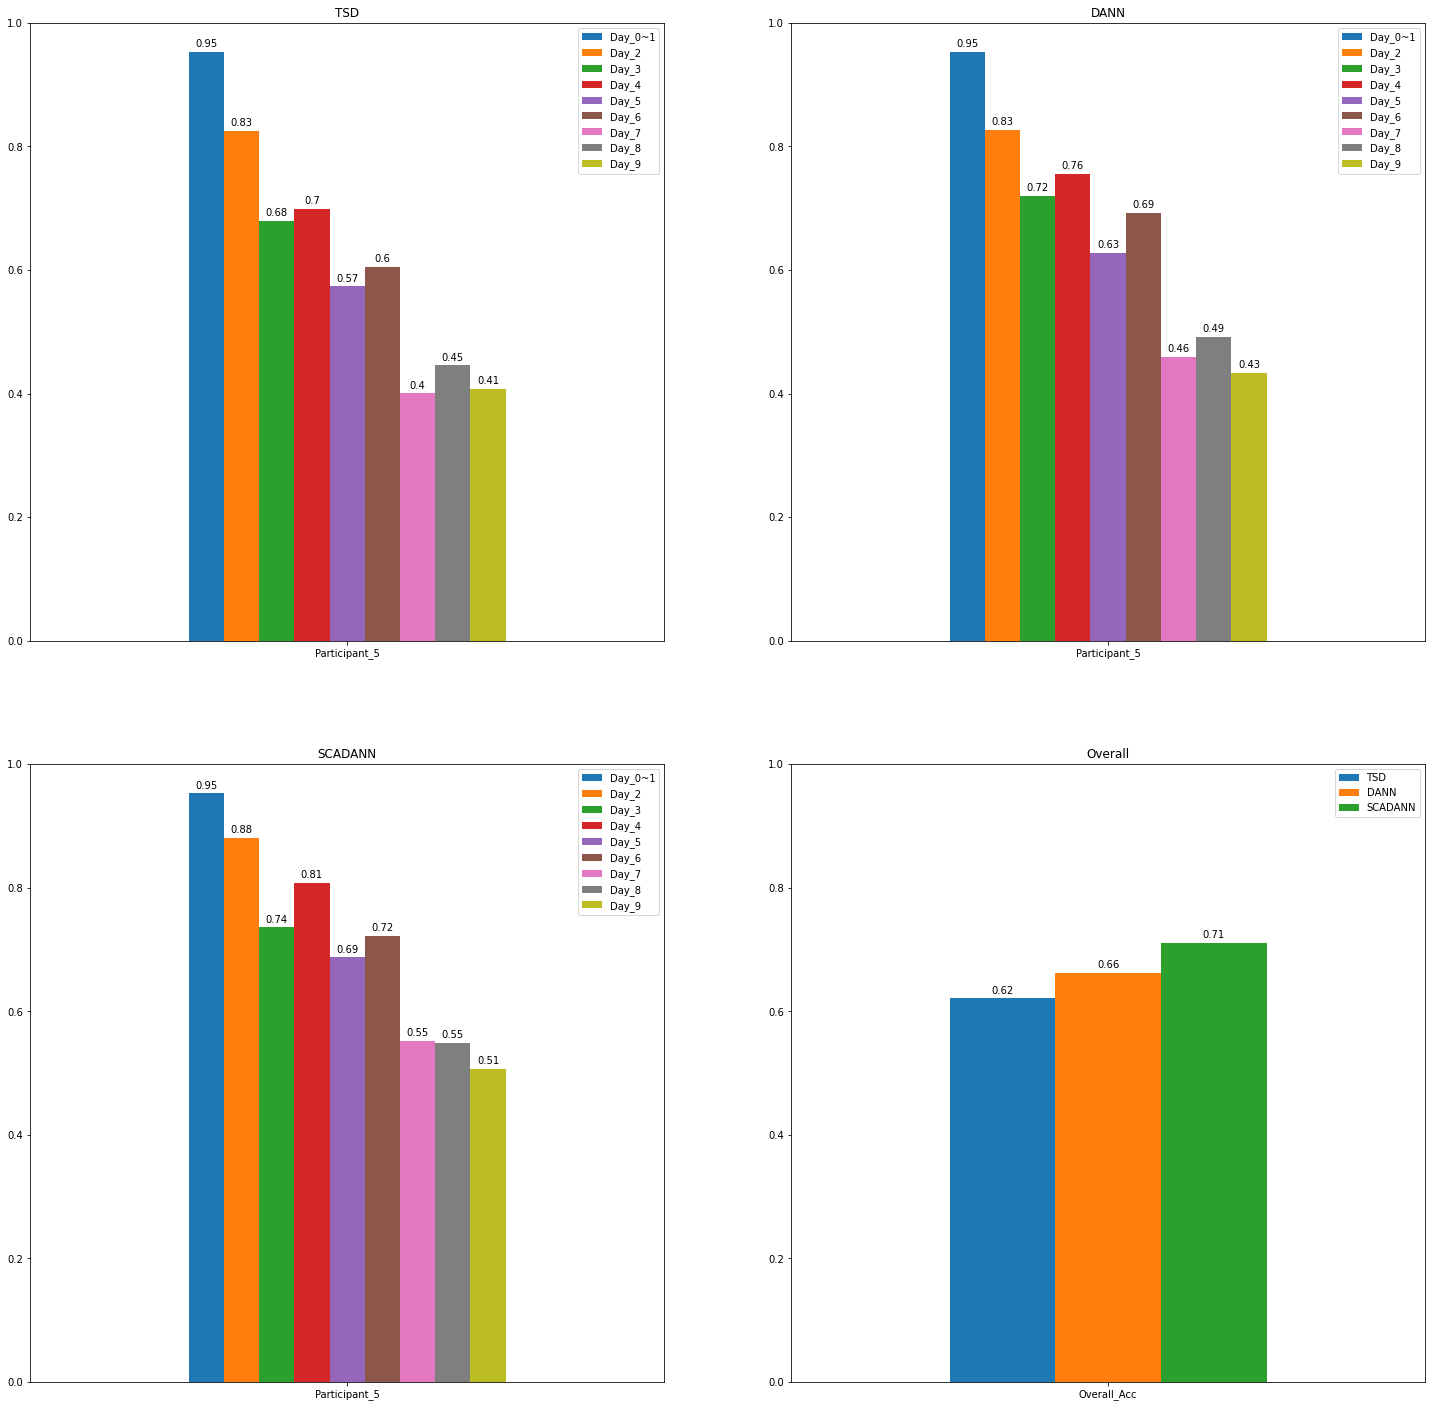

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(25,25))
acc_list = [TSD_df, DANN_df, SCADANN_df, overall_acc_df]
title_list = ["TSD", "DANN", "SCADANN", "Overall"]
for idx, ax in enumerate(axes.reshape(-1)): 
    acc_list[idx].transpose().plot.bar(ax = ax, rot=0)
    ax.set_title(title_list[idx])
    ax.set_ylim([0, 1.0])
    for p in ax.patches:
        ax.annotate(str(np.round(p.get_height(),2)), (p.get_x()+p.get_width()/2., p.get_height()),
                    ha='center', va='center', xytext=(0, 8),textcoords='offset points')
